In [1]:
# filename: notebooks/Subreddit_Overview.ipynb (continued)

# Sort by raw subscriber count
df = df.sort_values("subscriber_count", ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 0.4 * len(df)))
bars = ax.barh(df["name"], df["subscriber_count"], color="steelblue")

for bar, pct, sub_count in zip(bars, df["pct_growth"], df["subscriber_count"]):
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2

    # Subscriber count inside bar
    ax.text(width / 2, y, f"{sub_count:,} subs", ha='center', va='center', fontsize=8, color="white")

    # Growth % at end
    ax.text(width + max(df["subscriber_count"]) * 0.005, y, f"{pct:+.1f}%", va='center',
            fontsize=8, color="green" if pct > 0 else "red")

ax.set_xlabel("Subscriber Count")
ax.set_title("Subreddits by Subscriber Count with 30-Day Growth")
ax.margins(y=0.01)
plt.tight_layout()

# Output text above chart
print(project_intro.strip())
print(f"\nTracking {total_subs} subreddits and {total_posts:,} posts")
print(f"Snapshot date: {latest_date}\n")

plt.show()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


NameError: name 'df' is not defined

In [44]:
# filename: notebooks/Subreddit_Overview.ipynb (continued)

from datetime import timedelta

# Ensure captured_at exists and is datetime
# hist_df["captured_at"] already parsed

# Define full 3-day range between min and max timestamps
full_bins = pd.date_range(
    start=hist_df["captured_at"].min().floor("D"),
    end=hist_df["captured_at"].max().ceil("D"),
    freq="3D"
)

# Bin data
hist_df["bin_3d"] = hist_df["captured_at"].dt.floor("3D")

# Count subreddits per 3-day bin
bin_counts = (
    hist_df.groupby("bin_3d")["subreddit_id"]
    .nunique()
    .reindex(full_bins, fill_value=0)  # Fill missing bins with 0
    .reset_index()
    .rename(columns={"index": "bin_3d", "subreddit_id": "snapshot_count"})
)

# Print with full bins, gaps included
print("\nSnapshot coverage every 3 days (gaps included):\n")
print(bin_counts.to_string(index=False))


Snapshot coverage every 3 days (gaps included):

    bin_3d  snapshot_count
2025-04-24              51
2025-04-27              51
2025-04-30              51
2025-05-03              51
2025-05-06              51
2025-05-09              51
2025-05-12              51
2025-05-15              51
2025-05-18               0
2025-05-21               0
2025-05-24               0
2025-05-27               0
2025-05-30               0
2025-06-02               0
2025-06-05              51
2025-06-08               0
2025-06-11               0
2025-06-14               0
2025-06-17               0
2025-06-20               0
2025-06-23              51


In [48]:
## Notes:

In [65]:
# filename: notebooks/Subreddit_Overview.ipynb (continued)

import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import pandas as pd
import numpy as np

# --- Data processing ---
hist_df["captured_at"] = pd.to_datetime(hist_df["captured_at"], unit="s")
hist_df["name"] = hist_df["name"].apply(lambda x: x if x.startswith("r/") else "r/" + x)

first_date_fixed = pd.Timestamp("2025-04-26")
last_date_actual = hist_df["captured_at"].max()
duration_days = (last_date_actual - first_date_fixed).days
months, days = divmod(duration_days, 30)

first_snap = hist_df[hist_df["captured_at"].dt.floor("D") == first_date_fixed]
first_counts = first_snap.sort_values("captured_at").groupby("name").tail(1)

last_snap = hist_df.sort_values("captured_at").groupby("name").tail(1)

merged = pd.merge(
    first_counts[["name", "subscriber_count"]],
    last_snap[["name", "subscriber_count", "captured_at"]],
    on="name",
    suffixes=("_first", "_last")
)

merged["_Growth"] = np.where(
    merged["subscriber_count_first"] > 0,
    100.0 * (merged["subscriber_count_last"] - merged["subscriber_count_first"]) / merged["subscriber_count_first"],
    0.0
)

merged["% Growth"] = merged["_Growth"].round(1)
merged["Subscribers"] = merged["subscriber_count_last"]
merged["First Snapshot"] = first_date_fixed.strftime("%Y-%m-%d")

base_df = merged[["name", "First Snapshot", "Subscribers", "% Growth", "_Growth"]]
base_df.columns = ["Subreddit", "First Snapshot", "Subscribers", "% Growth", "_Growth"]

# --- Widgets ---
sort_by = widgets.Dropdown(
    options=["Subscribers", "% Growth"],
    value="Subscribers",
    description="Sort by:",
)

# --- Styling function ---
def color_percent_map(val):
    if val < 0:
        return "color:#b22222;font-weight:bold;" if val <= -10 else "color:#e9967a;font-weight:bold;"
    else:
        return "color:#006400;font-weight:bold;" if val >= 10 else "color:#90ee90;font-weight:bold;"

# --- Table rendering ---
def render_table(sort_value):
    df = base_df.copy()
    sort_col = "Subscribers" if sort_value == "Subscribers" else "_Growth"
    df = df.sort_values(sort_col, ascending=False).reset_index(drop=True)
    df_display = df.drop(columns=["_Growth"])

    styled = df_display.style\
        .map(color_percent_map, subset=["% Growth"])\
        .format({"% Growth": "{:.1f}", "Subscribers": "{:,}"})

    header_html = f"""
    <table>
        <tr><th style='text-align:left'>Subreddit subscriber summary</th></tr>
        <tr><td>From <strong>{first_date_fixed.strftime('%Y-%m-%d')}</strong> to <strong>{last_date_actual.strftime('%Y-%m-%d')}</strong> — over <strong>{months} months, {days} days</strong></td></tr>
    </table><br>
    """
    display(HTML(header_html))
    display(styled)

# --- Use interactive_output instead of observe ---
ui = widgets.VBox([sort_by])
out = widgets.interactive_output(render_table, {"sort_value": sort_by})

# --- Final display ---
display(ui, out)

Output()

In [66]:
# Top Subreddits by Subscribers (with color-coded % Growth)

from IPython.display import display, HTML

subs_sorted = base_df.copy()
subs_sorted = subs_sorted.sort_values("Subscribers", ascending=False).reset_index(drop=True)  # numeric sort first
subs_sorted["% Growth"] = subs_sorted["_Growth"].round(1)
subs_sorted["Subscribers"] = subs_sorted["Subscribers"].map("{:,}".format)
subs_sorted = subs_sorted.drop(columns=["_Growth"])

def color_percent_map(val):
    if val < 0:
        return "color:#b22222; font-weight:bold;" if val <= -10 else "color:#e9967a; font-weight:bold;"
    else:
        return "color:#006400; font-weight:bold;" if val >= 10 else "color:#90ee90; font-weight:bold;"

header_html = f"""
<table>
    <tr><th style='text-align:left'>Subreddit subscriber summary</th></tr>
    <tr><td>From <strong>{first_date_fixed.strftime('%Y-%m-%d')}</strong> to <strong>{last_date_actual.strftime('%Y-%m-%d')}</strong> — over <strong>{months} months, {days} days</strong></td></tr>
</table><br>
"""

display(HTML(header_html))
display(HTML("<b>Top Subreddits by Subscribers</b><br><br>"))
display(
    subs_sorted.style
    .map(color_percent_map, subset=["% Growth"])
    .format({"% Growth": "{:.1f}"})
)

Subreddit subscriber summary
"From 2025-04-26 to 2025-06-24 — over 1 months, 29 days"


,Subreddit,First Snapshot,Subscribers,% Growth
0,r/WGU,2025-04-26,"150,424",3.1
1,r/WGU_CompSci,2025-04-26,"23,648",1.9
2,r/WGUCyberSecurity,2025-04-26,"21,470",2.4
3,r/WGUIT,2025-04-26,"17,684",1.5
4,r/wguaccounting,2025-04-26,"10,159",5.9
5,r/wgu_devs,2025-04-26,"9,593",3.3
6,r/WGU_MBA,2025-04-26,"7,928",5.8
7,r/wgueducation,2025-04-26,"6,802",5.0
8,r/WGU_Military,2025-04-26,"5,780",1.1
9,r/WGU_Accelerators,2025-04-26,"4,024",18.7


In [60]:
# Top Subreddits by % Growth (with color-coded % Growth)

growth_sorted = base_df.copy()
growth_sorted["% Growth"] = growth_sorted["_Growth"].round(1)
growth_sorted["Subscribers"] = growth_sorted["Subscribers"].map("{:,}".format)
growth_sorted = growth_sorted.sort_values("_Growth", ascending=False).drop(columns=["_Growth"]).reset_index(drop=True)

display(HTML("<b>Top Subreddits by % Growth</b><br><br>"))
display(
    growth_sorted.style
    .map(color_percent_map, subset=["% Growth"])
    .format({"% Growth": "{:.1f}"})
)

,Subreddit,First Snapshot,Subscribers,% Growth
0,r/WGUAccelerators,2025-04-26,361,21.5
1,r/WGU_Psychology,2025-04-26,371,19.7
2,r/WGU_Accelerators,2025-04-26,"4,024",18.7
3,r/WGUPSYCHOLOGY2425,2025-04-26,293,16.3
4,r/WGU_HumanResources,2025-04-26,93,12.0
5,r/wgu_employees,2025-04-26,923,10.1
6,r/WGU_BSHIM,2025-04-26,360,9.4
7,r/WGUMSHRM,2025-04-26,564,7.4
8,r/WGU_Business,2025-04-26,"3,288",7.2
9,r/WGUTeachersCollege,2025-04-26,"3,655",7.0



Snapshot coverage every 3 days (gaps included):

    bin_3d  snapshot_count
2025-04-24              51
2025-04-27              51
2025-04-30              51
2025-05-03              51
2025-05-06              51
2025-05-09              51
2025-05-12              51
2025-05-15              51
2025-05-18               0
2025-05-21               0
2025-05-24               0
2025-05-27               0
2025-05-30               0
2025-06-02               0
2025-06-05              51
2025-06-08               0
2025-06-11               0
2025-06-14               0
2025-06-17               0
2025-06-20               0
2025-06-23              51


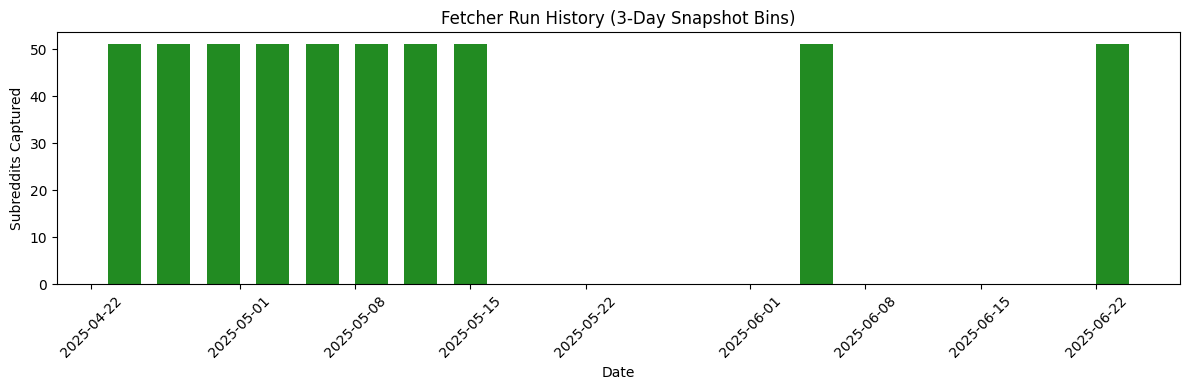

In [30]:
plt.figure(figsize=(12, 4))
plt.bar(bin_counts["bin_3d"], bin_counts["snapshot_count"], width=2, align="center", color="forestgreen")

plt.xlabel("Date")
plt.ylabel("Subreddits Captured")
plt.title("Fetcher Run History (3-Day Snapshot Bins)")
plt.xticks(rotation=45)
plt.yticks(range(0, 52, 10))
plt.tight_layout()
plt.show()

In [32]:
# filename: notebooks/Subreddit_Overview.ipynb (continued)

# Manually selected dates based on gap logic
snapshot_dates = [
    pd.Timestamp("2025-05-03"),
    pd.Timestamp("2025-05-15"),
    pd.Timestamp("2025-06-05"),
    pd.Timestamp("2025-06-23")
]

print("\nSelected snapshot dates (based on fetch gap pattern):\n")
for dt in snapshot_dates:
    print(dt.strftime("%Y-%m-%d"))


Selected snapshot dates (based on fetch gap pattern):

2025-05-03
2025-05-15
2025-06-05
2025-06-23


WGU Reddit Tracker

This dashboard analyzes 51 WGU-related subreddits using a snapshot of scraped post data.
Data includes subreddit metrics, posting trends, and demo sentiment/topic tagging.

Tracking 51 subreddits and 17,343 posts
Snapshot date: 2025-06-24



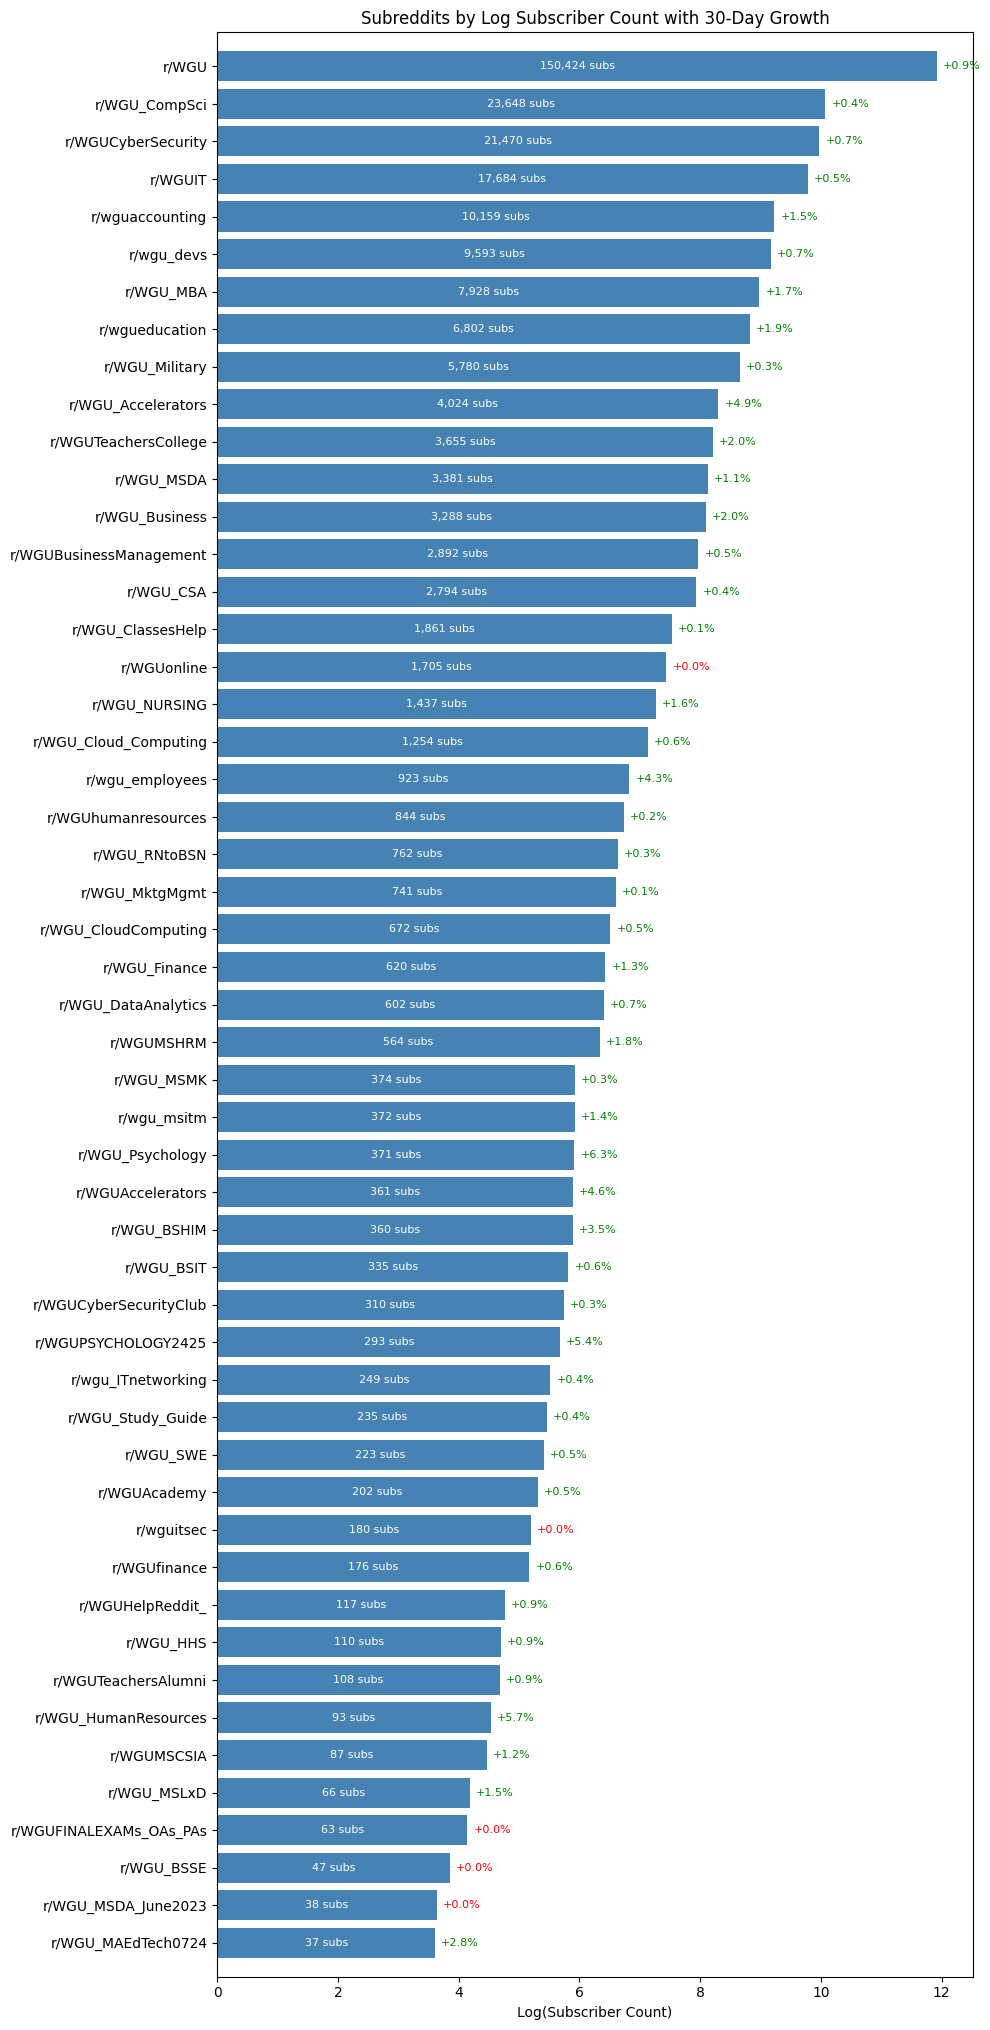

In [18]:
# filename: notebooks/Subreddit_Overview.ipynb

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timezone

# Connect to database
db_path = "/Users/buddy/Desktop/WGU-Reddit/db/WGU-Reddit.db"
conn = sqlite3.connect(db_path)

# Project intro (printed before chart)
project_intro = """
WGU Reddit Tracker

This dashboard analyzes 51 WGU-related subreddits using a snapshot of scraped post data.
Data includes subreddit metrics, posting trends, and demo sentiment/topic tagging.
"""

# Get summary stats
summary_query = """
SELECT
    (SELECT COUNT(*) FROM subreddits) AS total_subreddits,
    (SELECT COUNT(*) FROM posts) AS total_posts,
    (SELECT MAX(captured_at) FROM subreddit_stats) AS latest_capture
"""
summary = pd.read_sql_query(summary_query, conn)
total_subs = summary["total_subreddits"][0]
total_posts = summary["total_posts"][0]
latest_date = datetime.fromtimestamp(summary["latest_capture"][0], timezone.utc).strftime("%Y-%m-%d")

# Get current subscriber counts
subs_query = """
WITH latest_snapshot AS (
  SELECT subreddit_id, MAX(captured_at) AS last_ts
  FROM subreddit_stats
  GROUP BY subreddit_id
),
current_subs AS (
  SELECT ss.subreddit_id, ss.subscriber_count
  FROM subreddit_stats ss
  JOIN latest_snapshot ls ON ss.subreddit_id = ls.subreddit_id AND ss.captured_at = ls.last_ts
)
SELECT s.name, c.subscriber_count, c.subreddit_id
FROM current_subs c
JOIN subreddits s ON c.subreddit_id = s.subreddit_id
"""
subs_df = pd.read_sql_query(subs_query, conn)

# Get 30-day growth
growth_query = """
WITH recent_stats AS (
  SELECT subreddit_id, captured_at, subscriber_count
  FROM subreddit_stats
  WHERE captured_at >= (SELECT MAX(captured_at) - 30*86400 FROM subreddit_stats)
),
first_last AS (
  SELECT subreddit_id,
         MIN(subscriber_count) AS first_count,
         MAX(subscriber_count) AS last_count
  FROM recent_stats
  GROUP BY subreddit_id
)
SELECT subreddit_id, first_count, last_count,
       ROUND(100.0 * (last_count - first_count) / NULLIF(first_count, 0), 2) AS pct_growth
FROM first_last
"""
growth_df = pd.read_sql_query(growth_query, conn)
conn.close()

# Merge data and format labels
df = subs_df.merge(growth_df, on="subreddit_id", how="left").fillna(0)
df["name"] = "r/" + df["name"]
df["log_subs"] = np.log(df["subscriber_count"].replace(0, np.nan))  # Avoid log(0)
df = df.sort_values("log_subs", ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 0.4 * len(df)))
bars = ax.barh(df["name"], df["log_subs"], color="steelblue")

for bar, pct, sub_count in zip(bars, df["pct_growth"], df["subscriber_count"]):
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2

    # Overlay subscriber count with commas and 'subs' label
    ax.text(width / 2, y, f"{sub_count:,} subs", ha='center', va='center', fontsize=8, color="white")

    # Growth % at end of bar
    ax.text(width + 0.1, y, f"{pct:+.1f}%", va='center', fontsize=8, color="green" if pct > 0 else "red")

ax.set_xlabel("Log(Subscriber Count)")
ax.set_title("Subreddits by Log Subscriber Count with 30-Day Growth")
ax.margins(y=0.01)
plt.tight_layout()

# Output text above chart
print(project_intro.strip())
print(f"\nTracking {total_subs} subreddits and {total_posts:,} posts")
print(f"Snapshot date: {latest_date}\n")

plt.show()